# Bagging 

Notebook to train a bagging model.

Evaluation metrics:
  
+ MSE
+ RMSE
+ MAE
+ MAPE

Steps:

1. 5-fold on training set
2. Find the best hyper parameters
3. 5-fold as the final training set, re-train with the best hyper parameters
4. Save model
5. Measure the performance on the test set

In [2]:
import numpy as np
import pandas as pd

In [6]:
raw_test_df = pd.read_csv('../../statistical-learning/processed_test.csv')
raw_train_df = pd.read_csv('../../statistical-learning/processed_traning.csv')

## Preprocessing

In [21]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [18]:
display(raw_train_df.head(2))
raw_train_df.info()

,attendance,day,month,is_federal_holiday,venue,at_night,on_grass,temperature,wind_speed,weather,...,Starling-Marte,Joe-Musgrove,Joc-Pederson,Carlos-Rodon,Corey-Seager,Vladimir-Guerrero-Jr.,Byron-Buxton,salary-500-800,salary-800-1500,salary-1500
0,35055,Sunday,April,0,Wrigley Field,True,True,44,7,Sunny.,...,0,0,0,0,0,0,0,5,6,8
1,49043,Monday,April,0,Chase Field,True,True,81,7,Sunny.,...,0,0,0,0,0,0,0,7,6,6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12270 entries, 0 to 12269
Columns: 193 entries, attendance to salary-1500
dtypes: bool(2), float64(2), int64(183), object(6)
memory usage: 17.9+ MB


In [20]:
raw_train_df.iloc[:, :20].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12270 entries, 0 to 12269
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   attendance          12270 non-null  int64  
 1   day                 12270 non-null  object 
 2   month               12270 non-null  object 
 3   is_federal_holiday  12270 non-null  int64  
 4   venue               12270 non-null  object 
 5   at_night            12270 non-null  bool   
 6   on_grass            12270 non-null  bool   
 7   temperature         12270 non-null  int64  
 8   wind_speed          12270 non-null  int64  
 9   weather             12270 non-null  object 
 10  precipitation       12270 non-null  int64  
 11  team1_name          12270 non-null  object 
 12  team1_pre_win       12270 non-null  int64  
 13  team1_pre_loss      12270 non-null  int64  
 14  team1_pre_win_pct   12270 non-null  float64
 15  team1_streak        12270 non-null  int64  
 16  team

### Preprocessing Function

In [76]:
def process_data(data):
    processed_df = data.copy()
    processed_df['weather'] = processed_df['weather'].str.replace('.', '')
    
        
    # day, month to int
    # day: Sunday = 0, Monday = 1, ..., Saturday = 6
    day_dict = {'Sunday': 0, 'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6}
    # month: January = 1, February = 2, ..., December = 12
    month_dict = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}

    processed_df['day'] = processed_df['day'].map(day_dict)
    processed_df['month'] = processed_df['month'].map(month_dict)

    # others (string)
    to_be_encoded = ['team1_name', 'team2_name', 'venue', 'weather']

    # encoding
    le = LabelEncoder()
    for col in to_be_encoded:
        processed_df[col + '_label'] = le.fit_transform(processed_df[col])

        # drop object columns + 'attendance'
    X = processed_df.drop(to_be_encoded + ['attendance'], axis=1)
    y = processed_df['attendance']
    
    return X, y

In [34]:
processed_df = raw_train_df.copy()

In [35]:
# remove '.' from weather column
processed_df['weather'] = processed_df['weather'].str.replace('.', '')

/var/folders/j3/sr9rbcw10dzch_cpwn25txkh0000gn/T/ipykernel_94121/4104958986.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  processed_df['weather'] = processed_df['weather'].str.replace('.', '')


In [36]:
processed_df.weather.unique()

array(['Sunny', 'Overcast', 'Cloudy', 'Drizzle', 'In Dome', 'Rain'],
      dtype=object)

In [37]:

# day, month to int
# day: Sunday = 0, Monday = 1, ..., Saturday = 6
day_dict = {'Sunday': 0, 'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6}
# month: January = 1, February = 2, ..., December = 12
month_dict = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}

processed_df['day'] = processed_df['day'].map(day_dict)
processed_df['month'] = processed_df['month'].map(month_dict)

# others (string)
to_be_encoded = ['team1_name', 'team2_name', 'venue', 'weather']

# encoding
le = LabelEncoder()
for col in to_be_encoded:
    processed_df[col + '_label'] = le.fit_transform(processed_df[col])

In [38]:
processed_df.head(2)

,attendance,day,month,is_federal_holiday,venue,at_night,on_grass,temperature,wind_speed,weather,...,Corey-Seager,Vladimir-Guerrero-Jr.,Byron-Buxton,salary-500-800,salary-800-1500,salary-1500,team1_name_label,team2_name_label,venue_label,weather_label
0,35055,0,4,0,Wrigley Field,True,True,44,7,Sunny,...,0,0,0,5,6,8,26,4,40,5
1,49043,1,4,0,Chase Field,True,True,81,7,Sunny,...,0,0,0,7,6,6,24,0,4,5


In [40]:
# drop object columns + 'attendance'
X = processed_df.drop(to_be_encoded + ['attendance'], axis=1)
y = processed_df['attendance']

In [41]:
ss = StandardScaler()
scaled_X = ss.fit_transform(X)

## Model Building

### Model Evaluation Function

In [47]:
# MSE, RMSE, MAE, MAPE

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def measure_model(y_true, y_pred, verbose=True, title=''):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    if verbose:
        print(f'''{"="*10} {title} {"="*10}
MSE: {mse:.2f}
RMSE: {rmse:.2f}
MAE: {mae:.2f}
MAPE: {mape:.2f}''')

    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

In [53]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, cross_validate

### Simple Bagging Model

In [60]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)

# Bagging Regressor
regr = BaggingRegressor(n_estimators=10, random_state=42).fit(X_train, y_train)
y_pred_simple = regr.predict(X_test)

_ = measure_model(y_test, y_pred_simple, title='Simple Bagging Regressor')

========== Simple Bagging Regressor ==========
MSE: 26174158.76
RMSE: 5116.07
MAE: 3794.38
MAPE: 0.15


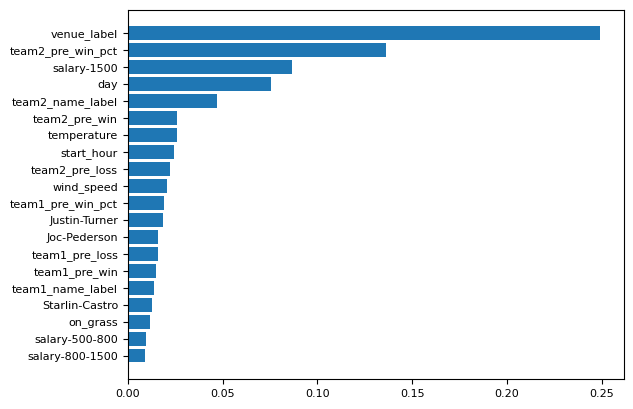

In [71]:
# matplotlib
import matplotlib.pyplot as plt

feature_importances = np.mean([
    tree.feature_importances_ for tree in regr.estimators_
], axis=0)

num_features = 20

indices = np.argsort(feature_importances)[::-1][:num_features]

fig, ax = plt.subplots()
ax.barh(range(num_features), feature_importances[indices][::-1])
ax.set_yticks(range(num_features))
_ = ax.set_yticklabels(np.array(X.columns)[indices][::-1])
# font size
plt.rcParams.update({'font.size': 8})

### Hyperparameter Tuning

In [72]:
# skf = StratifiedKFold(n_splits=5)
scoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']
n_estimators_grid = np.geomspace(5, 1000, 10, endpoint=True, dtype=int) # 10 numbers between 5 and 1000
n_estimators_dict = {}

for n_estimators in n_estimators_grid:
    regr = BaggingRegressor(n_estimators=n_estimators, random_state=42)
    results = cross_validate(regr, scaled_X, y, cv=5, scoring=scoring)

    metric_dict = {}
    metric_dict['MSE'] = results['test_neg_mean_squared_error'].mean()
    metric_dict['RMSE'] = results['test_neg_root_mean_squared_error'].mean()
    metric_dict['MAE'] = results['test_neg_mean_absolute_error'].mean()
    metric_dict['MAPE'] = results['test_neg_mean_absolute_percentage_error'].mean()
    metric_dict['fit_time'] = results['fit_time'].mean()
    metric_dict['score_time'] = results['score_time'].mean()

    n_estimators_dict[n_estimators] = metric_dict

### Use the best hyperparameters to train the model

In [80]:
metric_df = pd.DataFrame(n_estimators_dict).T.reset_index().rename(columns={'index': 'n_estimators'})
metric_df

,n_estimators,MSE,RMSE,MAE,MAPE,fit_time,score_time
0,5,-3.887506e+07,-6228.849726,-4691.829829,-0.195122,1.049795,0.017424
1,9,-3.567650e+07,-5966.079185,-4509.575360,-0.189205,1.914502,0.030227
2,16,-3.380500e+07,-5809.064611,-4397.080995,-0.184852,3.577594,0.055707
3,29,-3.289994e+07,-5730.830943,-4346.526369,-0.182818,7.664828,0.129634
4,52,-3.242576e+07,-5689.736878,-4320.339739,-0.181886,22.389346,0.253054
5,94,-3.224212e+07,-5673.682017,-4314.728040,-0.181898,27.351803,0.347505
6,170,-3.221550e+07,-5671.722801,-4311.559082,-0.181759,46.118185,0.833115
7,308,-3.213142e+07,-5664.265293,-4309.621974,-0.181804,77.638346,1.161956
8,555,-3.203305e+07,-5655.680200,-4301.484041,-0.181517,193.980739,3.754222
9,1000,-3.201356e+07,-5653.819368,-4300.757887,-0.181592,273.357752,4.567214


In [81]:
best_grid = metric_df[abs(metric_df['RMSE']) == abs(metric_df['RMSE']).min()]
best_rmse = best_grid['RMSE'].values[0]
best_nest = best_grid['n_estimators'].values[0]

print(f'Best number of trees = {best_nest} with RMSE = {best_rmse}')

Best number of trees = 1000 with RMSE = -5653.819367550194


In [87]:
regr = BaggingRegressor(n_estimators=1000, random_state=0).fit(scaled_X, y)

In [83]:
# save model in YYYYMMDD format
from datetime import datetime
import pickle

regr_filename = f'{datetime.today().strftime("%Y%m%d")}_bagging_model.pkl'
pickle.dump(regr, open(regr_filename, 'wb'))

### Feature Importance

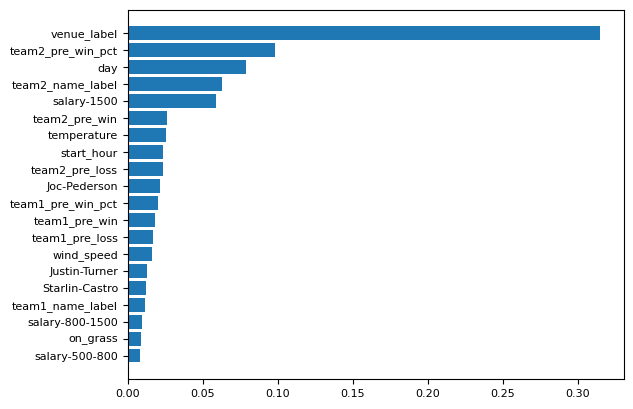

In [84]:
# matplotlib
import matplotlib.pyplot as plt

feature_importances = np.mean([
    tree.feature_importances_ for tree in regr.estimators_
], axis=0)

num_features = 20

indices = np.argsort(feature_importances)[::-1][:num_features]

fig, ax = plt.subplots()
ax.barh(range(num_features), feature_importances[indices][::-1])
ax.set_yticks(range(num_features))
_ = ax.set_yticklabels(np.array(X.columns)[indices][::-1])
# font size
plt.rcParams.update({'font.size': 8})

## Model Evaluation

In [85]:
X_test, y_test = process_data(raw_test_df)
ss = StandardScaler().fit(X_test)
scaled_X_test = ss.transform(X_test)

/var/folders/j3/sr9rbcw10dzch_cpwn25txkh0000gn/T/ipykernel_94121/1460645059.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  processed_df['weather'] = processed_df['weather'].str.replace('.', '')


In [88]:
# read model
import pickle
regr = pickle.load(open('20221125_bagging_model.pkl', 'rb'))
y_pred = regr.predict(scaled_X_test)

# performance
test_performance = measure_model(y_test, y_pred, title='Bagging Regressor')

========== Bagging Regressor ==========
MSE: 93801634.42
RMSE: 9685.12
MAE: 7561.61
MAPE: 0.46


Note:

+ The model doesn't perform well on the test set, which can be improved through following ways:
    1. Player data may be too noisy, we can try to cut down player features with PCA or maybe just use salary ranks
    2. Venue capacities vary a lot, it'd be better if we can first group venues by capacity and then train models for each group
+ Metrics looked good on the training set, but not on the testing set, which means the model is probably overfitting. We can try to reduce the number of features or use regularization to reduce overfitting
+ When comparing the bagging model with the baseline model, we see that baseline (MA-5) did slightly better (廢話), and **even using the average attendance per stadium does better job than bagging**. 

```
==================== MA(5) ====================
MSE:  32362577.913605437
RMSE:  5688.81164335799
MAE:  4399.588064076346
MAPE 0.21121206067333725
```

```
==================== Average Attendance Only ====================
MSE:  88887032.10373585
RMSE:  9427.991944403424
MAE:  7635.267692974473
MAPE 0.48553017390069386
```

```
========== Bagging Regressor ==========
MSE: 93801634.42
RMSE: 9685.12
MAE: 7561.61
MAPE: 0.46
```